In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
%matplotlib inline
plt.style.use("seaborn")
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
data = pd.read_csv("./datasets/Metro_time_series.csv")

In [3]:
cols = ['Date', 'RegionName', 'ZHVI_AllHomes']
data = data[data['ZHVI_AllHomes'] > 0]
data = data.filter(cols)
data = data.rename(columns={"RegionName": "CBSA_Code"})
cityList = np.unique(data['CBSA_Code'])
metro = []
for code in tqdm(cityList):
    metro.append(data[data['CBSA_Code']  == str(code)])


100%|██████████| 730/730 [00:05<00:00, 130.53it/s]


              Date CBSA_Code  ZHVI_AllHomes
48      1996-04-30     13020        65200.0
732     1996-05-31     13020        65400.0
1419    1996-06-30     13020        65900.0
2107    1996-07-31     13020        66300.0
2796    1996-08-31     13020        66700.0
...            ...       ...            ...
206695  2017-08-31     13020        89200.0
207606  2017-09-30     13020        89100.0
208517  2017-10-31     13020        89900.0
209428  2017-11-30     13020        90800.0
210339  2017-12-31     13020        91600.0

[261 rows x 3 columns]


NameError: name 'movingAverage_normalize' is not defined

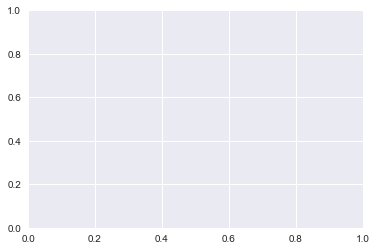

In [4]:
city1 = metro[0]
ames = data[data.CBSA_Code == '13020']
print(ames)
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(ames['Date'][4:]).dt.date, movingAverage_normalize(ames['ZHVI_AllHomes'].values))
# ax.scatter(pd.to_datetime('2009-05-31'), ames[ames['Date'] == '2009-05-31']['ZHVI_AllHomes'])

In [5]:
def movingAverage_normalize(a, n=5) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    moving_avg = ret[n - 1:] / n
    return np.array([(x-np.mean(moving_avg))/np.std(moving_avg) for x in moving_avg])
#fig, ax = plt.subplots()
#ax.scatter(pd.to_datetime(city1['Date'][4:]).dt.date, movingAverage_normalize(city1['ZHVI_AllHomes'].values))
#plt.show()
movingAverage_normalize(city1['ZHVI_AllHomes'].values)
# don't send moving average 
#  CHECK IF AFFECTS MOVING AVERAGE AFFECTS ARIMA

array([-1.52245317, -1.46376916, -1.41346858, -1.37993486, -1.36526386,
       -1.36631179, -1.37155143, -1.38517451, -1.41137273, -1.43547509,
       -1.44805023, -1.45957745, -1.46796088, -1.47424845, -1.48891945,
       -1.51826146, -1.55179518, -1.58847268, -1.61991055, -1.64610876,
       -1.67021113, -1.69221763, -1.70374485, -1.70164899, -1.68278627,
       -1.64925255, -1.60628747, -1.55913068, -1.51721353, -1.48787152,
       -1.46796088, -1.4470023 , -1.41870823, -1.37783901, -1.31810707,
       -1.24684791, -1.17768462, -1.11690475, -1.07079589, -1.03621424,
       -0.99744087, -0.94714029, -0.88950421, -0.8308202 , -0.78575927,
       -0.75956105, -0.74803383, -0.75012969, -0.76480069, -0.78156755,
       -0.78890305, -0.78995098, -0.79309477, -0.79099891, -0.78261548,
       -0.78156755, -0.78051962, -0.77108826, -0.76270484, -0.76165691,
       -0.76794448, -0.78051962, -0.79309477, -0.8088137 , -0.82138884,
       -0.8234847 , -0.82767642, -0.84549121, -0.86854564, -0.89

In [6]:
THRESHOLD = 1

def find_max_start(city):
    return type == str

def find_start(city):
    """
    returns recession start date, measured as the largest local maximum ZHVI for a given city
    takes: city (pd.dataframe) [Date, ZHVI_avg_norm]
    returns: start_date (pd.datetime)
    """
    city = city[city['Date'] < find_max_start(city)]
    d = lambda i: city['ZHVI_AllHomes'].iloc[i] - city['ZHVI_AllHomes'].iloc[i-1]
    diffs = np.array([d(i) for i in range(1, len(city))])
    # reshape dataframe to include diffs
    city = city.iloc[1:]
    city['Diffs'] = diffs
    # find local maxes using diffs
    is_max = np.array([(city['Diffs'].iloc[i] >= 0) 
                       and (city['Diffs'].iloc[i+1] <= 0) 
                       and (city['Diffs'].iloc[i+1] - city['Diffs'].iloc[i] <= THRESHOLD) for i in range(len(city) - 1)])
    is_max = np.append(is_max, False)

    # check for presence of local maxes at all
    if np.count_nonzero(is_max) == 0:
        return 0
    # add 'is_maximum' truth column to dataframe
    city['Max'] = is_max
    # filter and find largest max
    theMax = city[city['Max'] == 1.0].sort_values("ZHVI_AllHomes", ascending=False).iloc[0]
    start_date = theMax['Date']
    return start_date

In [7]:
failed_cities = []
def ARIMA_50(city, start, params=(5,1,1)):
    """
    Params:
    city -- time-series dataframe object containing Date and ZHVI columns
    start -- datetime object from index of city representing peak ZHVI
    params -- p, d, and q parameters for ARIMA
    """
    
    #add start.dt.strftime('%Y-%m-%d') to convert datetime to string
    
    from statsmodels.tsa.arima_model import ARIMA
    
    before = city[['Date', 'ZHVI_AllHomes']][city['Date'] < start].set_index(['Date'])['ZHVI_AllHomes'].values
    steps = city.shape[0] - before.shape[0]
    try:
        model = ARIMA(before, order=(5, 1, 1))
        model_fit = model.fit(disp=0)
        return model_fit.forecast(steps)[0]
    except:
        failed_cities.append(np.unique(city.CBSA_Code)[0])
        return np.repeat(city[city['Date'] == start].ZHVI_AllHomes, steps)

In [8]:
def find_end(city, start, ARIMA_50):
    """
    returns recession end date, measured as the first point of intersection between ZHVI and ARIMA_50 for a given city
    takes: city (pd.dataframe) [Date, ZHVI_avg_norm], ARIMA_50 (pd.dataframe) [Date, forecasted_ZHVI_norm] 
    returns: end_date (pd.datetime)
    """
    # calculate diffs
    recession_ZHVI = city[city['Date'] >= start]
    diffs = ARIMA_50 - recession_ZHVI['ZHVI_AllHomes'].values
    city_resid = pd.DataFrame(data={'Date': recession_ZHVI['Date'].values, 'Delta': diffs})
    # filter only positive residuals, and most recent one is the last recession date
    most_recent_positive_delta = city_resid[city_resid['Delta'] > 0].sort_values("Date", ascending=False)
    print(most_recent_positive_delta.shape)
    end_date = most_recent_positive_delta['Date'].iloc[0]
    return end_date

In [9]:
def calc_resid(city, predicted, start, end):
    """
    Params:
    city -- time-series dataframe object containing Date and ZHVI columns
    predicted -- predicted values from max to last date of city time-series
    max -- datetime object from index of city representing peak ZHVI
    end -- datetime object from index of city representing intersection of 
    actual and predicted ZHVI or last date of actual
    """
    
    # get indices of start and end date and use those to splice arrays
    recession_ZHVI = city[city['Date'] >= start]
    recession_ZHVI = recession_ZHVI[recession_ZHVI['Date'] < end]
    end_index = len(recession_ZHVI)
    predicted_to_end = predicted[:end_index]
    diffs = predicted_to_end - recession_ZHVI['ZHVI_AllHomes'].values
    return sum(diffs)

In [10]:
def find_AU3(metro):
    print("City: {}".format(np.unique(metro.CBSA_Code)))
    start = find_start(metro)
    arima = ARIMA_50(metro, start)
#     print("Start Date: ", start)
    fig, ax = plt.subplots()
    ax.plot(pd.to_datetime(metro['Date'][4:]).dt.date, movingAverage_normalize(metro['ZHVI_AllHomes'].values))
    print(metro[metro['Date'] > start].shape)
    end = find_end(metro, start, arima)
#     print("End Date: ", end)
    return calc_resid(metro, arima, start, end)

City: ['10140']
(124, 3)
(125, 2)
City: ['10220']
(45, 3)
(13, 2)
City: ['10300']
(143, 3)
(144, 2)
City: ['10420']
(128, 3)
(129, 2)
City: ['10500']
(117, 3)
(118, 2)
City: ['10540']
(121, 3)
(122, 2)
City: ['10580']
(123, 3)
(124, 2)
City: ['10620']
(121, 3)
(122, 2)
City: ['10740']
(103, 3)
(103, 2)
City: ['10780']
(94, 3)
(74, 2)
City: ['10820']
(128, 3)
(129, 2)
City: ['10900']
(126, 3)
(127, 2)
City: ['10940']
(138, 3)
(139, 2)
City: ['11020']


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(130, 3)
(131, 2)
City: ['11060']
(170, 3)
(171, 2)
City: ['11100']
(120, 3)
(120, 2)
City: ['11180']
(85, 3)
(85, 2)
City: ['11220']
(98, 3)
(99, 2)
City: ['11260']
(114, 3)
(113, 2)
City: ['11380']
(53, 3)
(53, 2)
City: ['11420']


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


(137, 3)
(138, 2)
City: ['11460']


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(152, 3)
(152, 2)
City: ['11540']
(84, 3)
(85, 2)
City: ['11580']
(139, 3)
(140, 2)
City: ['11620']
(69, 3)
(40, 2)
City: ['11680']
(106, 3)
(106, 2)
City: ['11700']
(117, 3)
(118, 2)
City: ['11740']
(169, 3)
(166, 2)
City: ['11780']
(139, 3)
(140, 2)
City: ['11860']
(64, 3)
(55, 2)
City: ['11940']
(101, 3)
(102, 2)
City: ['12020']
(118, 3)
(119, 2)
City: ['12060']
(133, 3)
(134, 2)
City: ['12100']
(139, 3)
(140, 2)
City: ['12140']
(148, 3)
(149, 2)
City: ['12180']
(97, 3)
(97, 2)
City: ['12220']
(118, 3)
(119, 2)
City: ['12260']
(78, 3)
(78, 2)
City: ['12300']


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(135, 3)
(136, 2)
City: ['12380']
(138, 3)
(138, 2)
City: ['12420']
(79, 3)
(8, 2)
City: ['12460']
(125, 3)
(126, 2)
City: ['12540']
(138, 3)
(139, 2)
City: ['12580']
(133, 3)
(134, 2)
City: ['12620']
(141, 3)
(142, 2)
City: ['12660']
(97, 3)
(97, 2)
City: ['12700']
(141, 3)
(140, 2)
City: ['12740']


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(153, 3)
(154, 2)
City: ['12780']
(82, 3)
(76, 2)
City: ['12820']
(74, 3)
(29, 2)
City: ['12860']
(39, 3)
(8, 2)
City: ['12900']
(40, 3)
(38, 2)
City: ['12940']
(97, 3)
(98, 2)
City: ['12980']
(144, 3)
(144, 2)
City: ['13020']
(144, 3)
(0, 2)


/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in add
  **kwargs)).imag/2./hess[i, j]
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


IndexError: single positional indexer is out-of-bounds

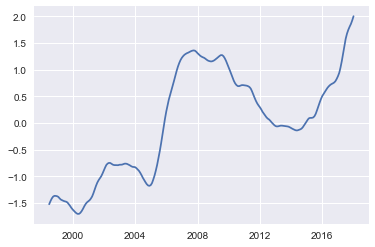

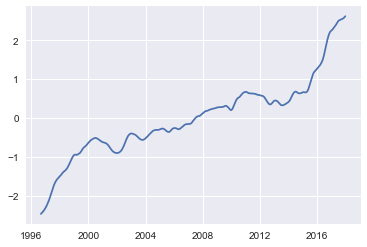

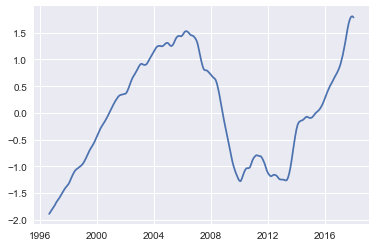

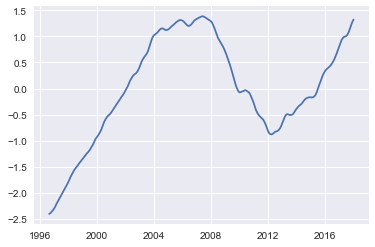

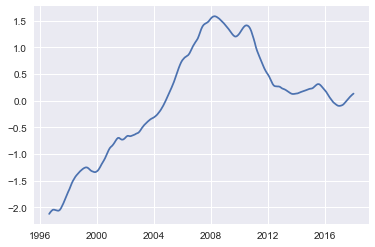

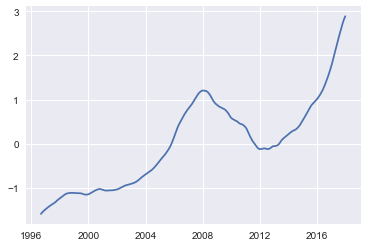

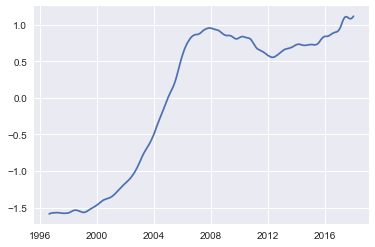

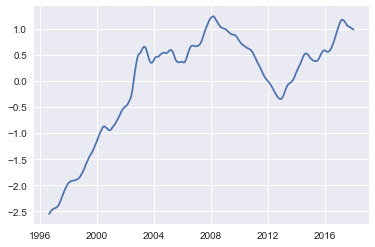

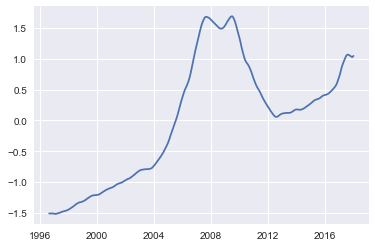

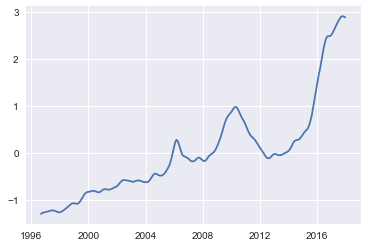

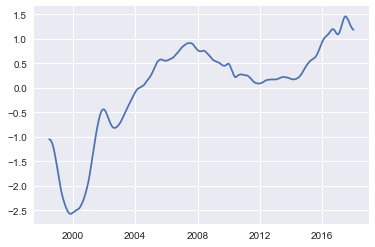

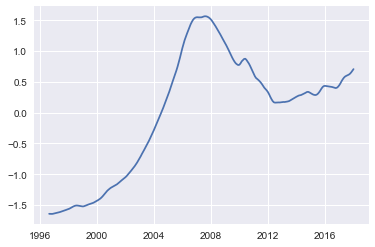

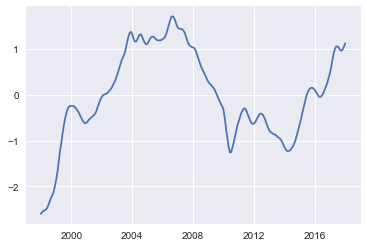

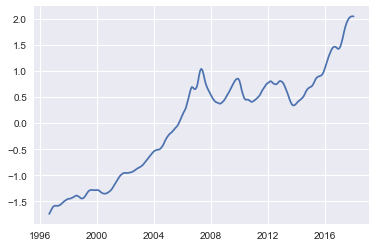

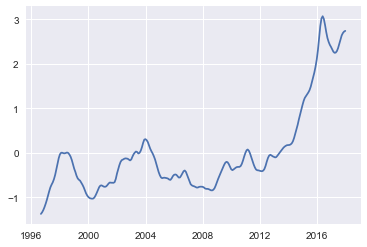

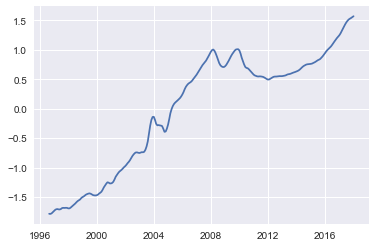

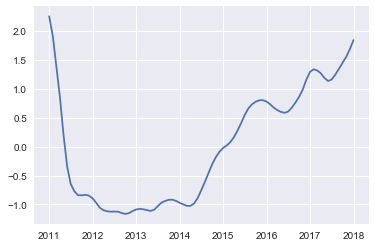

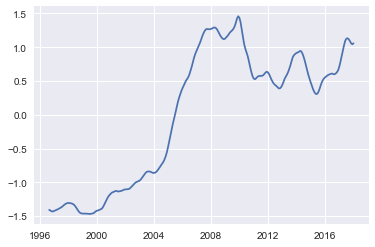

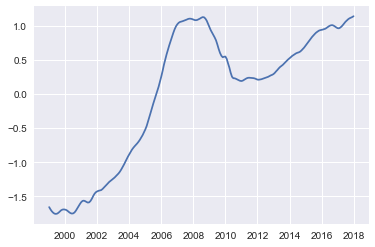

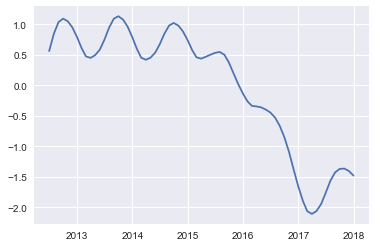

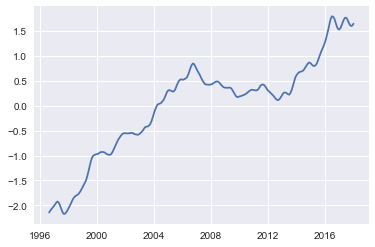

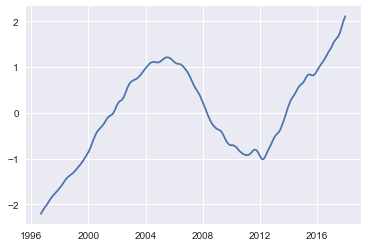

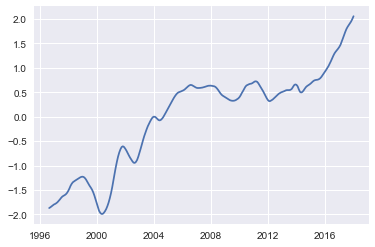

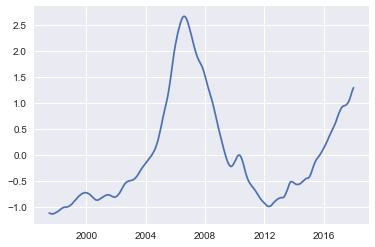

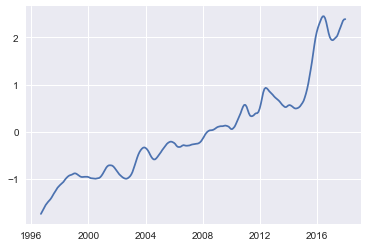

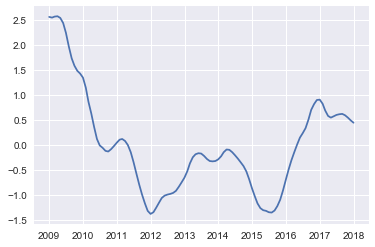

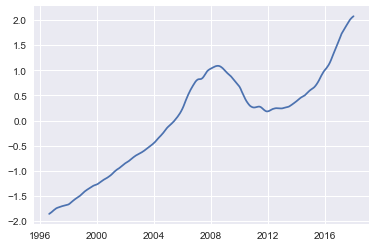

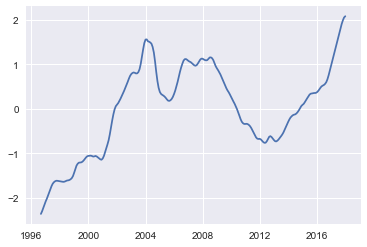

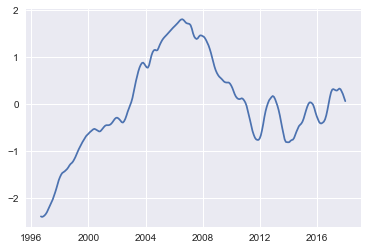

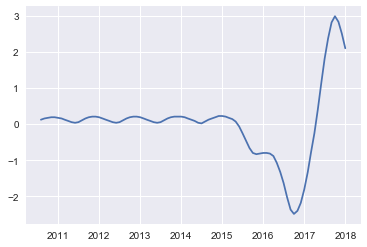

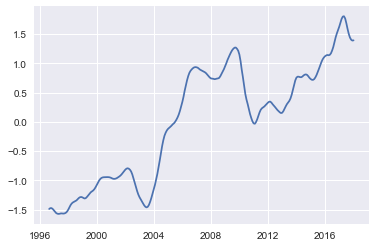

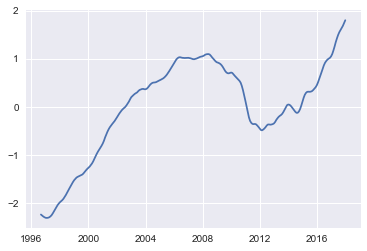

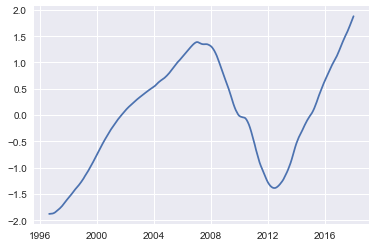

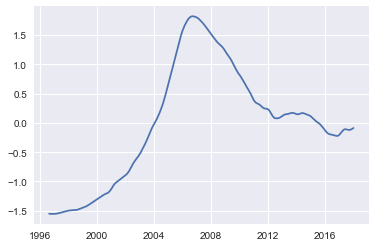

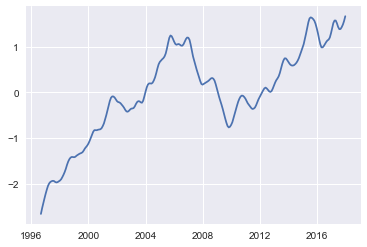

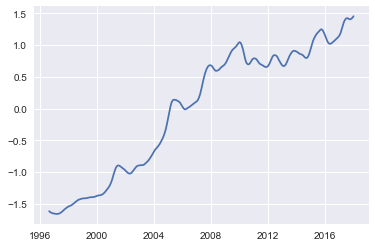

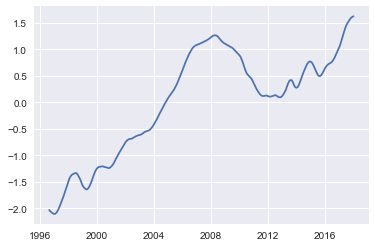

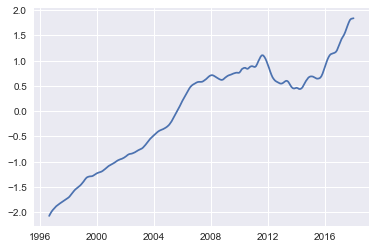

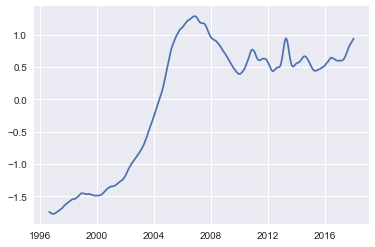

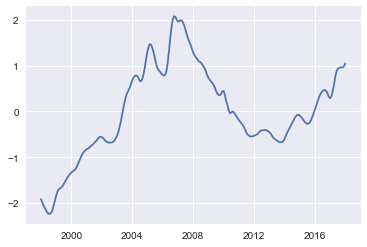

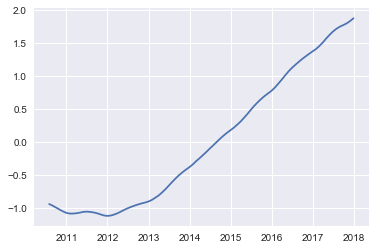

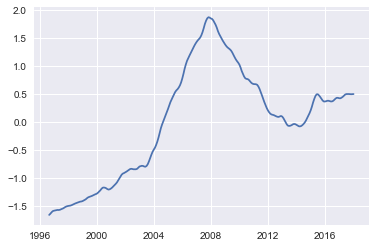

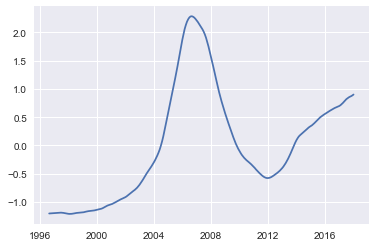

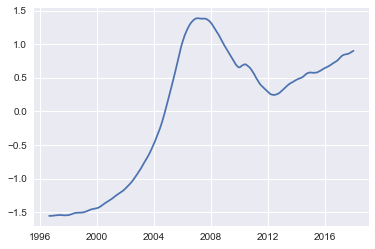

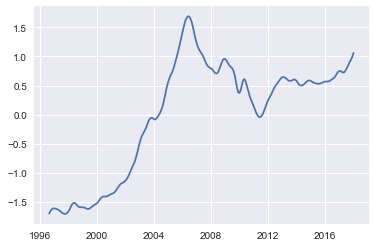

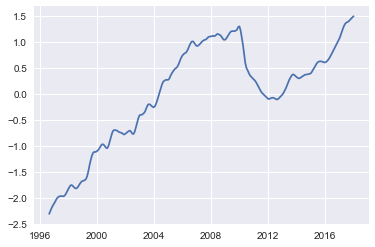

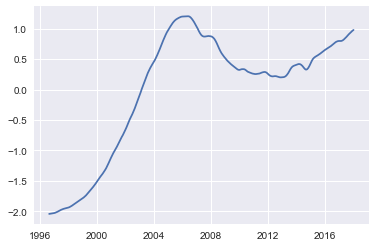

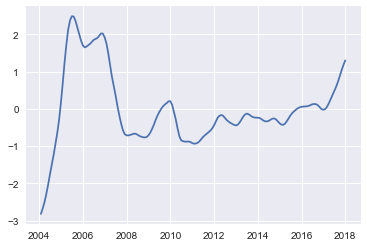

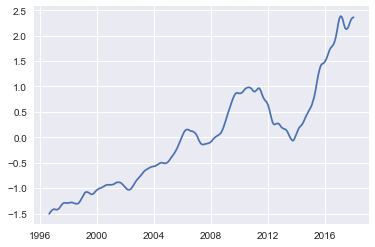

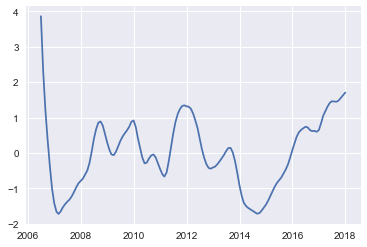

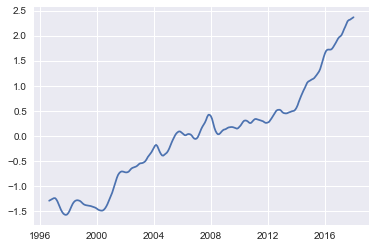

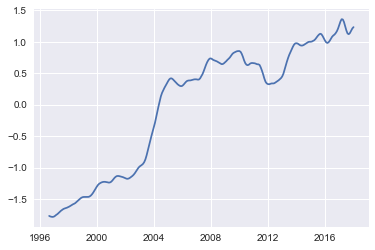

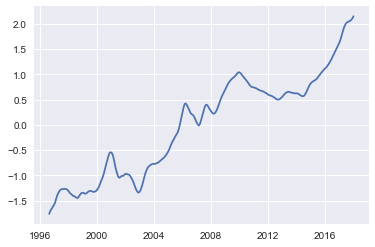

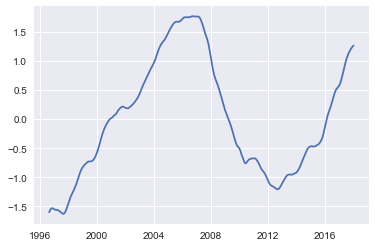

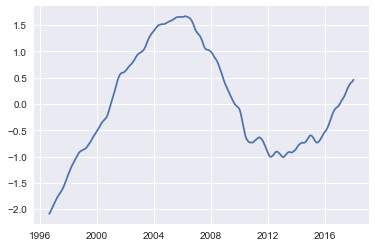

In [11]:
AU3_output = list(map(find_AU3, metro))

In [12]:
failed_cities

['11180', '11380', '11680', '12420']

## Everything below this cell is experimental/debugging

In [ ]:
# RANDOM STUFF DELETE LATER

from statsmodels.tsa.arima_model import ARIMA
city1.tail()
before = city1[['Date', 'ZHVI_AllHomes']][city1['Date'] < '2017-08-31'].set_index(['Date'])['ZHVI_AllHomes']
model = ARIMA(endog=np.array(before, dtype=np.float), order=(5, 1, 1))
model_fit = model.fit(disp=0)
#np.array(before, dtype=np.float)[0]
#city1['dt'] = city1
#np.array(city1['Date'], dtype='datetime64')
model_fit.predict(before.shape[0], city1.shape[0])

In [ ]:
city1 = city1[city1['Date'] < "2012"]
d = lambda i: city1['ZHVI_AllHomes'].iloc[i] - city1['ZHVI_AllHomes'].iloc[i-1]
diffs = np.array([d(i) for i in range(1, len(city1))])
# reshape dataframe to include diffs
city1 = city1.iloc[1:]
city1['Diffs'] = diffs
city1['Diffs']
# find local maxes using diffs
is_max = np.array([(city1['Diffs'].iloc[i] >= 0) and (city1['Diffs'].iloc[i+1] <= 0) for i in range(len(city1) - 1)])
is_max = np.append(is_max, False)

# check for presence of local maxes at all
if np.count_nonzero(is_max) == 0:
    print(0)
# add 'is_maximum' truth column to dataframe
city1['Max'] = is_max
# filter and find largest max
theMax = city1[city1['Max'] == 1.0].sort_values("ZHVI_AllHomes", ascending=False).iloc[0]
start_date = theMax['Date']
start_date